# LLM assignment
In this assignment I try to train and fine-tune a pre-trained medium-sized BERT type LLM to a downstream task of my choosing. I've decided to fine-tune DistilBERT on a rotten tomatoes movie reviews dataset from huggingface for the task of masked language modelling.

## Huggingface login and installations

In [ ]:
from huggingface_hub import login
login()

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 18.4 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
!pip install wordcloud


## Library imports and funtion definitions

In [ ]:
import collections
import numpy as np
import math
import torch
import matplotlib.pyplot as plt
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
from datasets import load_dataset
from datasets import DatasetDict
from wordcloud import WordCloud
from transformers import default_data_collator
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from huggingface_hub import get_full_repo_name
from huggingface_hub import Repository
from tqdm.auto import tqdm
from transformers import pipeline
from huggingface_hub import get_full_repo_name
from huggingface_hub import Repository

In [ ]:
def tokenize_function(examples):
    """
    Tokenizes input text examples and adds word IDs if the tokenizer is fast.

    Args:
        examples (dict): A dictionary containing text data under the key "text".

    Returns:
        dict: A dictionary with tokenized input features, including "input_ids".
              If the tokenizer is fast, "word_ids" are also included, mapping
              tokens to their corresponding words in the original text.
    """
    result = tokenizer(examples["text"])
    if tokenizer.is_fast:
        result["word_ids"] = [result.word_ids(i) for i in range(len(result["input_ids"]))]
    return result

def group_texts(examples):
    """
    Groups input texts into chunks of a specified size, truncating any leftover
     tokens that do not fit into a full chunk. Also creates a labels column
     that is a copy of the input IDs.

    Args:
        examples (dict): A dictionary containing lists of tokenized input IDs
        and other features.

    Returns:
        dict: A dictionary containing the input features grouped into chunks of
        the specified size,with an added "labels" column that is a copy of
         the "input_ids".
    """
    # Concatenate all texts
    concatenated_examples = {k: sum(examples[k], []) for k in examples.keys()}
    # Compute length of concatenated texts
    total_length = len(concatenated_examples[list(examples.keys())[0]])
    # We drop the last chunk if it's smaller than chunk_size
    total_length = (total_length // chunk_size) * chunk_size
    # Split by chunks of max_len
    result = {
        k: [t[i : i + chunk_size] for i in range(0, total_length, chunk_size)]
        for k, t in concatenated_examples.items()
    }
    # Create a new labels column
    result["labels"] = result["input_ids"].copy()
    return result

def whole_word_masking_data_collator(features):
    """
    Data collator for applying whole word masking to a batch of tokenized input
    features.

    This function modifies the input features in-place by randomly selecting
    entire words and masking all tokens corresponding to those words. Masked
    tokens are replaced with the tokenizer's mask token ID, and the labels are
    adjusted so that only the masked tokens are used for the loss calculation.

    Args:
        features (list): A list of dictionaries, where each dictionary contains
                         tokenized input features, including 'input_ids',
                         'labels', and 'word_ids'. 'word_ids' is used to map
                         tokens back to their original words.

    Returns:
        dict: A dictionary containing the modified batch of input features,
              ready for MLM with whole word masking applied.
    """

    for feature in features:
        word_ids = feature.pop("word_ids")

        # Create a map between words and corresponding token indices
        mapping = collections.defaultdict(list)
        current_word_index = -1
        current_word = None
        for idx, word_id in enumerate(word_ids):
            if word_id is not None:
                if word_id != current_word:
                    current_word = word_id
                    current_word_index += 1
                mapping[current_word_index].append(idx)

        # Randomly mask words
        mask = np.random.binomial(1, wwm_probability, (len(mapping),))
        input_ids = feature["input_ids"]
        labels = feature["labels"]
        new_labels = [-100] * len(labels)
        for word_id in np.where(mask)[0]:
            word_id = word_id.item()
            for idx in mapping[word_id]:
                new_labels[idx] = labels[idx]
                input_ids[idx] = tokenizer.mask_token_id
        feature["labels"] = new_labels

    return default_data_collator(features)

def insert_random_mask(batch):
    features = [dict(zip(batch, t)) for t in zip(*batch.values())]
    masked_inputs = data_collator(features)
    # Create a new "masked" column for each column in the dataset
    return {"masked_" + k: v.numpy() for k, v in masked_inputs.items()}

## Downlaoding the model and the dataset

In [ ]:
# Downloading distilbert
model_checkpoint = "distilbert-base-uncased"
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Checking the number of parameters
distilbert_num_parameters = model.num_parameters() / 1_000_000
print(f"'>>> DistilBERT number of parameters: {round(distilbert_num_parameters)}M'")

'>>> DistilBERT number of parameters: 67M'


Let's first check how the model will do before fine-tuning.

In [ ]:
# getting tokenizer to produce inputs for the model
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# My sample texts
text1 = "The [MASK] of Dune: Part Two was INCREDIBLE."
text2 = "It was the most boring [MASK] I've ever seen"

for text in [text1, text2]:
    inputs = tokenizer(text, return_tensors="pt")
    token_logits = model(**inputs).logits
    # Find the location of [MASK] and extract its logits
    mask_token_index = torch.where(inputs["input_ids"] == tokenizer.mask_token_id)[1]
    mask_token_logits = token_logits[0, mask_token_index, :]
    # Pick the [MASK] candidates with the highest logits
    top_5_tokens = torch.topk(mask_token_logits, 5, dim=1).indices[0].tolist()

    print(f"Original text: {text}")
    for token in top_5_tokens:
        print(f">>> {text.replace(tokenizer.mask_token, tokenizer.decode([token]))}")
    print("-" * 50)  # Separator for clarity between texts

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

I've decided to use the Rotten tomatoes dataset of containing 5,331 positive and 5,331 negative processed sentences from Rotten Tomatoes movie reviews.<br> Pang, B., & Lee, L. (2005). Seeing stars: Exploiting class relationships for sentiment categorization with respect to rating scales. In Proceedings of the ACL.

In [ ]:
ds = load_dataset("cornell-movie-review-data/rotten_tomatoes")

Generating train split:   0%|          | 0/8530 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1066 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})

## EDA

In [ ]:
# Check the overall structure
print(ds)

# Show a sample from the train set
print(ds['train'].features)

# View the first few samples
print(ds['train'][:5])


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1066
    })
})
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['neg', 'pos'], id=None)}
{'text': ['the rock is destined to be the 21st century\'s new " conan " and that he\'s going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .', 'the gorgeously elaborate continuation of " the lord of the rings " trilogy is so huge that a column of words cannot adequately describe co-writer/director peter jackson\'s expanded vision of j . r . r . tolkien\'s middle-earth .', 'effective but too-tepid biopic', 'if you sometimes like to go to the movies to have fun , wasabi is a good place to start .', "emerges as something rare , an issue movie that's so honest and keenl

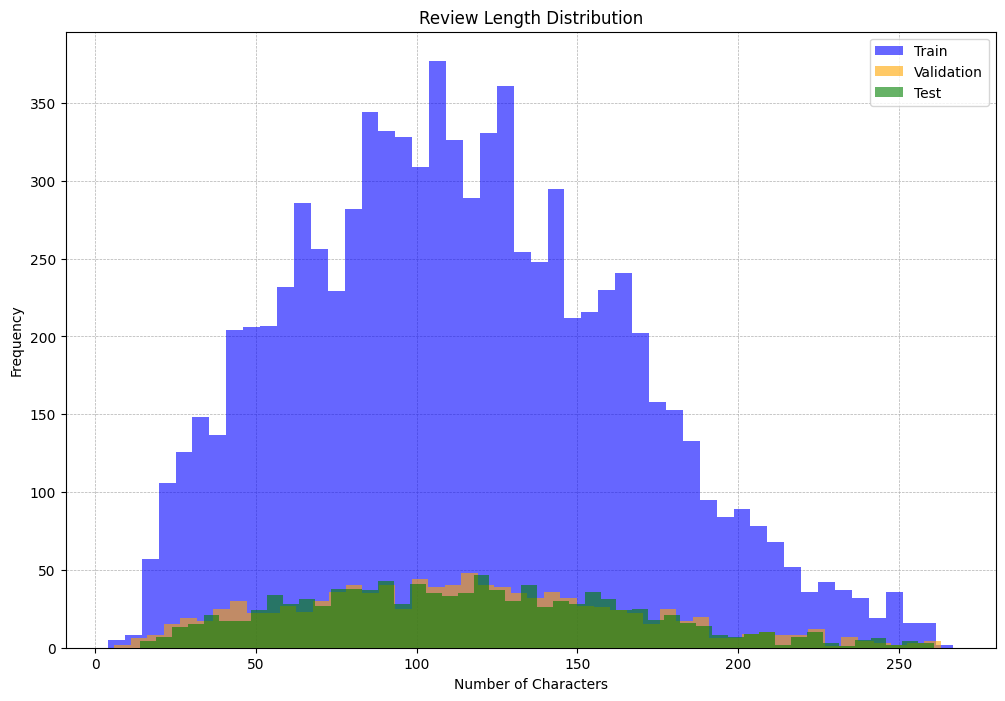

In [ ]:
# Convert datasets to pandas DataFrames
train_df = ds['train'].to_pandas()
validation_df = ds['validation'].to_pandas()
test_df = ds['test'].to_pandas()

# Add a column for text length
train_df['text_length'] = train_df['text'].apply(len)
validation_df['text_length'] = validation_df['text'].apply(len)
test_df['text_length'] = test_df['text'].apply(len)

# Plot the distribution of review lengths
plt.figure(figsize=(12, 8))
plt.hist(train_df['text_length'], bins=50, alpha=0.6, color='b', label='Train',
         zorder=3)
plt.hist(validation_df['text_length'], bins=50, alpha=0.6, color='orange',
         label='Validation', zorder=3)
plt.hist(test_df['text_length'], bins=50, alpha=0.6, color='g', label='Test',
         zorder=3)
plt.title('Review Length Distribution')
plt.xlabel('Number of Characters')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=0)
plt.show()


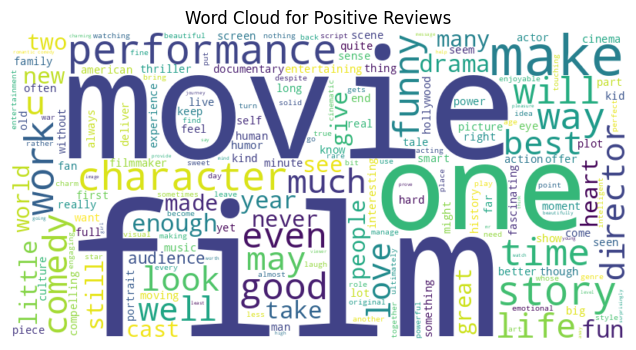

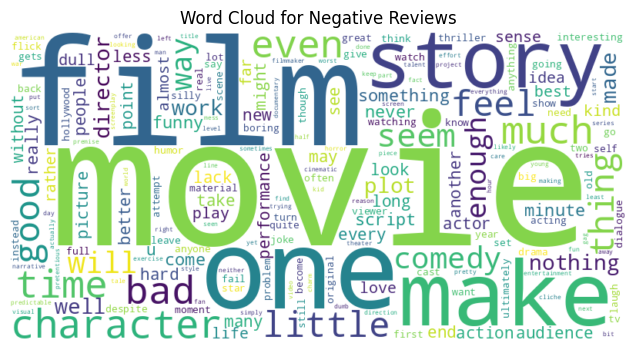

In [ ]:
# Word cloud for positive reviews
positive_text = ' '.join(train_df[train_df['label'] == 1]['text'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(positive_text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Positive Reviews')
plt.show()

# Word cloud for negative reviews
negative_text = ' '.join(train_df[train_df['label'] == 0]['text'])
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(negative_text)
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Negative Reviews')
plt.show()


## Pre-processing

In [ ]:
# Use batched=True to activate fast multithreading!
tokenized_datasets = ds.map(
    tokenize_function, batched=True, remove_columns=["text", "label"]
)
tokenized_datasets

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 8530
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 1066
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids'],
        num_rows: 1066
    })
})

In [ ]:
# Checking maximum context size to decide chunk size
tokenizer.model_max_length

512

In [ ]:
# Function to cpncatenate and split into chunks
chunk_size = 128

In [ ]:
# Mapping group_texts function to our tokenizd dataset
lm_datasets = tokenized_datasets.map(group_texts, batched=True)
lm_datasets

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1820
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 226
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 230
    })
})

## Fine-tuning with the trainer API

In [ ]:
# collator to randomnly mask tokens
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm_probability=0.15)

In [ ]:
# function to create another collator that will mask words as a whole
wwm_probability = 0.2

In [ ]:
# Downsampling traingin set cause of gpu restrictions
train_size = 1500
test_size = int(0.1 * train_size)

downsampled_dataset = lm_datasets["train"].train_test_split(
    train_size=train_size, test_size=test_size, seed=42
)
downsampled_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'word_ids', 'labels'],
        num_rows: 150
    })
})

In [ ]:
# Specifying trainer parameters
batch_size = 64
# Show the training loss with every epoch
logging_steps = len(downsampled_dataset["train"]) // batch_size
model_name = model_checkpoint.split("/")[-1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-rottentomatoestemp",
    overwrite_output_dir=True,
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    weight_decay=0.01,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    push_to_hub=True,
    fp16=True,
    logging_steps=logging_steps,
    remove_unused_columns=False
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=downsampled_dataset["train"],
    eval_dataset=downsampled_dataset["test"],
    data_collator=whole_word_masking_data_collator,
    tokenizer=tokenizer,
)

In [ ]:
# Using perplexity as an evaluation metric
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 148.69


In [ ]:
# Training
trainer.train()

Epoch,Training Loss,Validation Loss
1,4.512100,4.122392
2,4.170300,4.109545
3,4.112000,4.006074


TrainOutput(global_step=72, training_loss=4.260394652684529, metrics={'train_runtime': 32.6326, 'train_samples_per_second': 137.899, 'train_steps_per_second': 2.206, 'total_flos': 149131300608000.0, 'train_loss': 4.260394652684529, 'epoch': 3.0})

In [ ]:
# Checking perplexity again to sse if the domain adaptation improved the results
eval_results = trainer.evaluate()
print(f">>> Perplexity: {math.exp(eval_results['eval_loss']):.2f}")

>>> Perplexity: 56.98


In [ ]:
trainer.push_to_hub()

events.out.tfevents.1723649762.dbe9223434f3.640.1:   0%|          | 0.00/354 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/gobucbabu/distilbert-base-uncased-finetuned-rottentomatoestemp/commit/7c77fc19fd2e83159218f1bbcf0a3241442015b0', commit_message='End of training', commit_description='', oid='7c77fc19fd2e83159218f1bbcf0a3241442015b0', pr_url=None, pr_revision=None, pr_num=None)

## Fine-tuning with Huggingface Accelerate
This gives us more control. I'm gonna use a cistom training loop here.

In [ ]:
downsampled_dataset = downsampled_dataset.remove_columns(["word_ids"])
eval_dataset = downsampled_dataset["test"].map(
    insert_random_mask,
    batched=True,
    remove_columns=downsampled_dataset["test"].column_names,
)
eval_dataset = eval_dataset.rename_columns(
    {
        "masked_input_ids": "input_ids",
        "masked_attention_mask": "attention_mask",
        "masked_labels": "labels",
    }
)

Map:   0%|          | 0/150 [00:00<?, ? examples/s]

In [ ]:
# Setting up dataloader and using default collator for evaluation set
batch_size = 64
train_dataloader = DataLoader(
    downsampled_dataset["train"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
eval_dataloader = DataLoader(
    eval_dataset, batch_size=batch_size, collate_fn=default_data_collator
)

In [ ]:
# Loading fresh version of pre-trained model
model = AutoModelForMaskedLM.from_pretrained(model_checkpoint)

In [ ]:
# Specifying the optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

In [ ]:
# Preparing everything with the acceleartor object
accelerator = Accelerator()
model, optimizer, train_dataloader, eval_dataloader = accelerator.prepare(
    model, optimizer, train_dataloader, eval_dataloader
)

In [ ]:
# Specifying the learning rate scheduler
num_train_epochs = 3
num_update_steps_per_epoch = len(train_dataloader)
num_training_steps = num_train_epochs * num_update_steps_per_epoch

lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [ ]:
model_name = "distilbert-base-uncased-finetuned-rottentomatoestemp"
repo_name = get_full_repo_name(model_name)
repo_name

'gobucbabu/distilbert-base-uncased-finetuned-rottentomatoestemp'

In [ ]:
! cd /content/distilbert-base-uncased-finetuned-rottentomatoestemp
! git init
! git remote add origin <repo_url>
! git pull origin main


hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
/bin/bash: -c: line 1: syntax error near unexpected token `newline'
/bin/bash: -c: line 1: ` git remote add origin <repo_url>'
fatal: 'origin' does not appear to be a git repository
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.


In [ ]:
from huggingface_hub import Repository

new_output_dir = "tempfolder123"
repo = Repository(
    new_output_dir,
    clone_from=repo_name,
    git_user="gobucbabu",
    git_email="gobubabu9044@gmail.com"
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_deprecation.py:131: FutureWarning: 'Repository' (from 'huggingface_hub.repository') is deprecated and will be removed from version '1.0'. Please prefer the http-based alternatives instead. Given its large adoption in legacy code, the complete removal is only planned on next major release.
For more details, please read https://huggingface.co/docs/huggingface_hub/concepts/git_vs_http.
  warnings.warn(warning_message, FutureWarning)
/content/tempfolder123 is already a clone of https://huggingface.co/gobucbabu/distilbert-base-uncased-finetuned-rottentomatoestemp. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
# Full training and evaluation loop
# Initialize a list to store perplexity values
perplexity_values = []

progress_bar = tqdm(range(num_training_steps))

for epoch in range(num_train_epochs):
    # Training
    model.train()
    for batch in train_dataloader:
        outputs = model(**batch)
        loss = outputs.loss
        accelerator.backward(loss)

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

    # Evaluation
    model.eval()
    losses = []
    for step, batch in enumerate(eval_dataloader):
        with torch.no_grad():
            outputs = model(**batch)

        loss = outputs.loss
        losses.append(accelerator.gather(loss.repeat(batch_size)))

    losses = torch.cat(losses)
    losses = losses[: len(eval_dataset)]
    try:
        perplexity = math.exp(torch.mean(losses))
    except OverflowError:
        perplexity = float("inf")

    # Store the perplexity value
    perplexity_values.append(perplexity)

    print(f">>> Epoch {epoch}: Perplexity: {perplexity}")

    # Save and upload
    accelerator.wait_for_everyone()
    unwrapped_model = accelerator.unwrap_model(model)
    unwrapped_model.save_pretrained(output_dir, save_function=accelerator.save)
    if accelerator.is_main_process:
        tokenizer.save_pretrained(output_dir)
        repo.push_to_hub(
            commit_message=f"Training in progress epoch {epoch}", blocking=False
        )

  0%|          | 0/72 [00:00<?, ?it/s]

>>> Epoch 0: Perplexity: 15.541340003860844
>>> Epoch 1: Perplexity: 15.364914922622367
>>> Epoch 2: Perplexity: 15.364914922622367


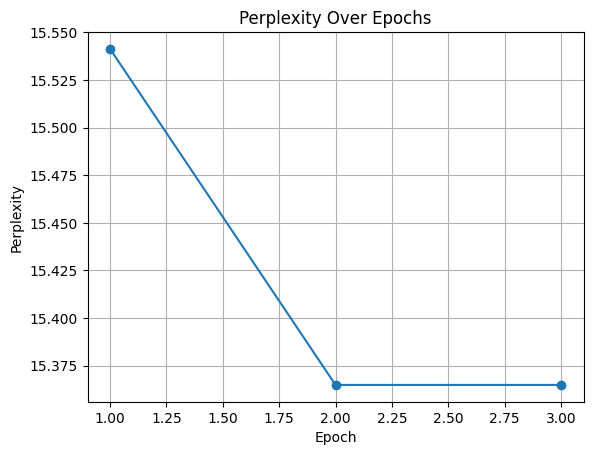

In [ ]:
# Plot perplexity values after training
plt.plot(range(1, num_train_epochs + 1), perplexity_values, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.title("Perplexity Over Epochs")
plt.grid(True)
plt.show()

Ckecking if the fine tuning changed anything.

In [ ]:
# Using pipeline to interact locally with the model
mask_filler = pipeline(
    "fill-mask", model="distilbert-base-uncased-finetuned-rottentomatoestemp"
)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
# Checking again with my texts
# Loop through each text and use the pipeline to fill the [MASK]
for text in [text1, text2]:
    preds = mask_filler(text)

    print(f"Original text: {text}")
    for pred in preds:
        print(f">>> {pred['sequence']}")
    print("-" * 50)

Original text: The [MASK] of Dune: Part Two was INCREDIBLE.
>>> the adventures of dune : part two was incredible.
>>> the legend of dune : part two was incredible.
>>> the art of dune : part two was incredible.
>>> the best of dune : part two was incredible.
>>> the history of dune : part two was incredible.
--------------------------------------------------
Original text: The colour [MASK] was beautiful
>>> the colouration was beautiful
>>> the colour it was beautiful
>>> the colour that was beautiful
>>> the colour which was beautiful
>>> the colour of was beautiful
--------------------------------------------------
Original text: It was the most boring [MASK] I've ever seen
>>> it was the most boring movie i've ever seen
>>> it was the most boring film i've ever seen
>>> it was the most boring thing i've ever seen
>>> it was the most boring one i've ever seen
>>> it was the most boring scene i've ever seen
--------------------------------------------------
Original text: [MASK] was 

TypeError: list indices must be integers or slices, not str